# Objective
The goal of this project is to use Convolutional Neural Networks (CNNs) to try and identify potential cancer in the lypmph nodes. 

### About the Data
The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from microscopic examinations or histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. The dataset is divided into a training set of 262.144 (2^18) examples, and a validation and test set both of 32.768 (2^15) examples. There is no overlap in WSIs between the splits, and all splits have a 50/50 balance between positive and negative examples. The data can be found [here](https://github.com/basveeling/pcam)

## Import Libraries

In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, io, models, ops, utils
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import ToTensor

print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))
data_dir = '../input/histopathologic-cancer-detection/'

220025
57458


## Import Data

In [22]:
train_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(f'No. of training examples:{len(train_df)}')

No. of training examples:220025


In [23]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [30]:
test_files = os.listdir('../input/histopathologic-cancer-detection/test')
print(f'No. of testing examples:{len(test_files)}')

No. of testing examples:57458


It appears that our training dataframe has 220,025 observations and our test files contain 57,458 images. It looks like we have a 80% and 20% train test split. 

# Exploratory Data Analysis

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [40]:
train_df.label.unique()

array([0, 1])

We don't have any labels that are not either `1` or `0`.

### Check for duplicates

In [41]:
train_df[train_df.duplicated(keep=False)]

,id,label


No duplicate `id` or `label` found in our dataset.

### Malignant vs Benign
Let us identify our cases using the given labels in the csv file. We know that an observation with a value of `1` indicates our histophathological image is malignant and `0` is benign.

0    130908
1     89117
Name: label, dtype: int64


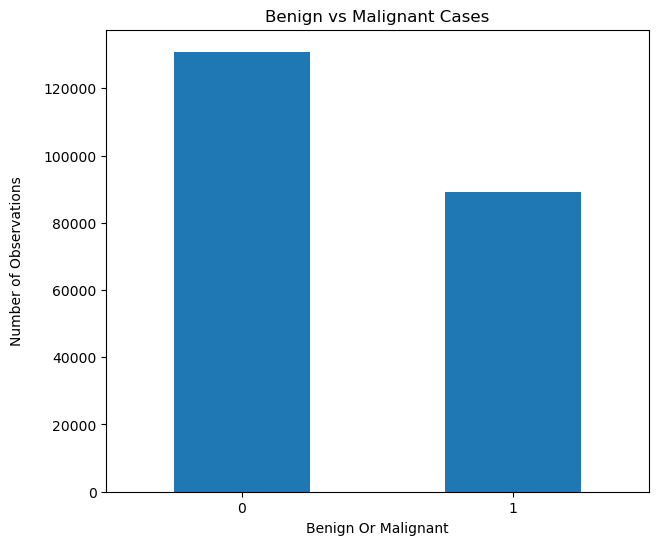

In [42]:
benignOrMalignant = train_df['label'].value_counts().plot(kind='bar', figsize=(7,6), rot=0)
plt.xlabel('Benign Or Malignant')
plt.ylabel('Number of Observations', labelpad=14)
plt.title('Benign vs Malignant Cases')
print(train_df.label.value_counts())



In our `train_df` dataframe the distribution between benign and malignant cases were 130,908 and 89,117 respectively. 

### Load Images
I used Pytorch's `torchvison` library which has a plethora of useful packages used for computer vision. The easiest way to load the data is using `ImageFolder` and `transform`.  The first is a method that allows us to load the images and one of the parameters it takes is `transform` which allows us to convert the image to a `Tensor` image with is a tensor with (C, H, W) shape. Where `C` is the number of channels or depth, ` H` and `W` are the image dimensions. To train our model we need to make sure all our images are the same size.

### Uniform Image Size

In [97]:
dataset = ImageFolder(data_dir, transform=T.ToTensor())
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 96, 96]) 0


tensor([[[0.8784, 0.7529, 0.9765,  ..., 0.4235, 0.8235, 0.9686],
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 0.9098, 1.0000],
         [0.3333, 0.3804, 0.7020,  ..., 0.4078, 0.5725, 0.5137],
         ...,
         [0.6000, 0.6431, 0.7882,  ..., 0.6000, 0.7098, 0.6000],
         [0.7961, 0.6196, 0.6196,  ..., 0.7608, 0.4000, 0.3725],
         [0.7608, 0.8941, 0.7333,  ..., 0.6235, 0.2549, 0.4745]],

        [[0.7765, 0.6549, 0.8980,  ..., 0.3412, 0.7412, 0.8863],
         [0.8510, 0.9529, 0.9451,  ..., 0.9608, 0.7804, 0.9020],
         [0.1294, 0.1843, 0.5176,  ..., 0.2392, 0.3804, 0.3020],
         ...,
         [0.3451, 0.3804, 0.5216,  ..., 0.3608, 0.4549, 0.3373],
         [0.5608, 0.3765, 0.3686,  ..., 0.5373, 0.1608, 0.1176],
         [0.5373, 0.6706, 0.5020,  ..., 0.4039, 0.0235, 0.2275]],

        [[0.7882, 0.6667, 0.9059,  ..., 0.3686, 0.7608, 0.9059],
         [0.9216, 1.0000, 1.0000,  ..., 1.0000, 0.8471, 0.9686],
         [0.2784, 0.3294, 0.6510,  ..., 0.3451, 0.5059, 0.

After converting our images to a tensor we are able to identify the size of our images. `img.shape` returned the size of each image as you can see our images are in shape of `[3,96,96]` where the `3` represents our channel. Since our images are color images our chanel size is `3` where red, green and blue are a vector and the length and width of each image is `96 pixels`. 

## Example Image

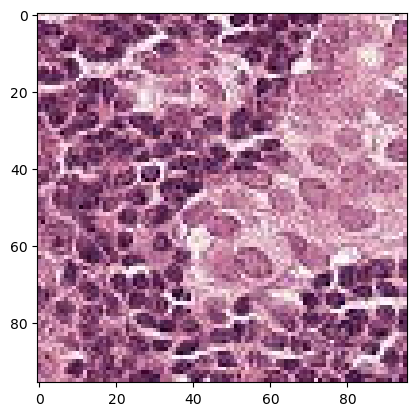

In [103]:
def show_img(img, label):
    plt.imshow(img.permute(1,2,0))

show_img(*dataset[0])

As you can see our image s